In [ ]:
!pip install sonopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from IPython.display import Audio, Image
import os
import glob
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm  import tqdm
from sonopy import mfcc_spec
from scipy import signal
from scipy.io import wavfile

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# os.chdir('drive/MyDrive/Speech_recognition')
# os.getcwd()

## Download data





In [ ]:
DATASET_PATH = 'data/mini_speech_commands'

if not os.path.isdir(DATASET_PATH):
    tf.keras.utils.get_file(
            'mini_speech_commands.zip',
            origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
            extract=True,
            cache_dir='.', cache_subdir='data')


182091776/182082353 [==============================] - 1s 0us/step


In [ ]:
all_classes = os.listdir(DATASET_PATH)
all_classes.remove('README.md')
print('all available classes:\n', all_classes)

all available classes:
 ['yes', 'down', 'right', 'left', 'no', 'stop', 'up', 'go']


In [ ]:
X = []  # record data path
for label in all_classes:
    path = DATASET_PATH+'/'+label
    X.extend(glob.glob(os.path.join(path, '*.wav')))

y = [path.split('/')[-2] for path in X]

print('data array length:', len(X))
print('label array length:', len(y))


le = preprocessing.LabelEncoder()
le.fit(y)  # y == y_train in human language
y = le.transform(y)  # y == (#y,) 0, 1, 2, ..

labels = le.classes_

encoder_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print(le.classes_)
print(encoder_mapping)

if not os.path.exists('encoder_mapping.pkl'):
    import pickle
    with open('encoder_mapping.pkl', 'wb') as f:
        pickle.dump(encoder_mapping, f)

data array length: 8000
label array length: 8000
['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']
{0: 'down', 1: 'go', 2: 'left', 3: 'no', 4: 'right', 5: 'stop', 6: 'up', 7: 'yes'}


In [ ]:
print(X[0], y[0])
Audio(X[0])

data/mini_speech_commands/yes/10627519_nohash_2.wav 7


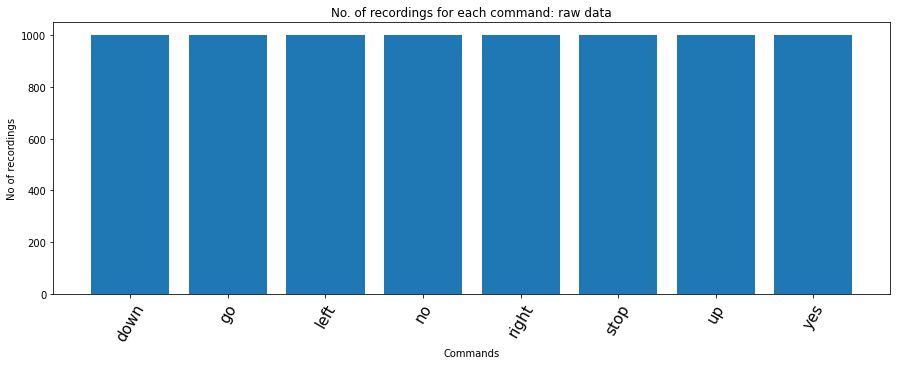

In [ ]:
no_of_recordings = []
for i in range(len(labels)):
    no_of_recordings.append(list(y).count(i))

plt.figure(figsize=(15,5))
index = range(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=10)
plt.ylabel('No of recordings', fontsize=10)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command: raw data')
plt.show()

In [ ]:
# split in train / test / val : 80% / 10% / 10%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=123)


print('training samples:', len(X_train))
print('testing samples:', len(X_test))
print('validation samples:',len(X_val))


training samples: 6400
testing samples: 800
validation samples: 800


In [ ]:
# keep test_data for test case
data_save_flag = False
if data_save_flag:
  import shutil
  test_data_folder = 'test_data'
  if os.path.isdir(test_data_folder):
    shutil.rmtree(test_data_folder)

  os.mkdir(test_data_folder)
  for file_name, y in zip(X_test, y_test):
    label_folder = os.path.join(test_data_folder, encoder_mapping[y])
    if not os.path.isdir(label_folder):
      os.mkdir(label_folder)
    shutil.copy(file_name, label_folder)

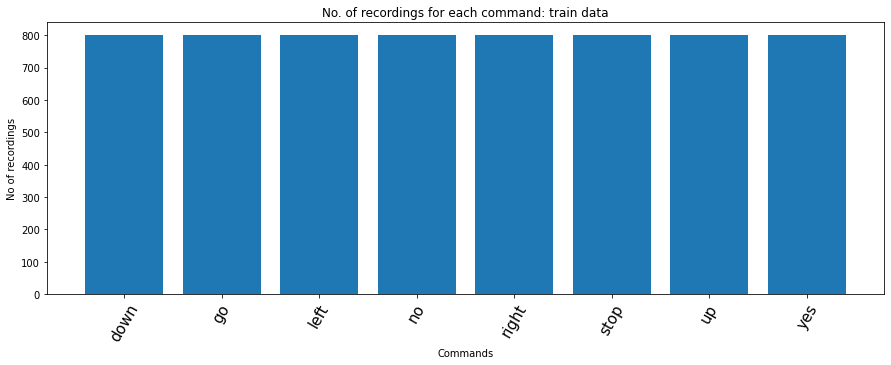

In [ ]:
no_of_recordings = []
for i in range(len(labels)):
  no_of_recordings.append(list(y_train).count(i))

plt.figure(figsize=(15, 5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=10)
plt.ylabel('No of recordings', fontsize=10)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command: train data')
plt.show()

## Preprocessing

In [ ]:
def normalize(audio_signal):
  
    return np.array(audio_signal) / max(np.absolute(audio_signal))

In [ ]:
def add_padding(audio_signal,desired_len):
  
    length_signal = len(audio_signal)
    if length_signal < desired_len:
        zeros = list(np.zeros(desired_len - length_signal))
        cut = random.randint(0, len(zeros))
        left = zeros[:cut]
        right = zeros[cut:]

        audio_signal = left + list(audio_signal) + right
    
    return audio_signal

Now, we want to extract the waveforms (i.e. the numerical data) from the .wav files.

In [ ]:
def get_signal(path):
  
    rate, sig = wavfile.read(filename=path)
    # sample rate == 16 000
    try:
        sig = sig[:, 0]
        
    except:
        pass
    
    
    #normalization
    sig = normalize(sig)

    #standardization of sizes
    sig = add_padding(sig, 16000)
    
    return sig

## Load data

In [ ]:
# extract all the np arrays from the .wav files

X_train_waveform = [get_signal(path) for path in tqdm(X_train,position=0)]
X_test_waveform = [get_signal(path) for path in tqdm(X_test,position=0)]
X_val_waveform = [get_signal(path) for path in tqdm(X_val,position=0)]

100%|██████████| 800/800 [00:01<00:00, 509.25it/s]


## Data visualization

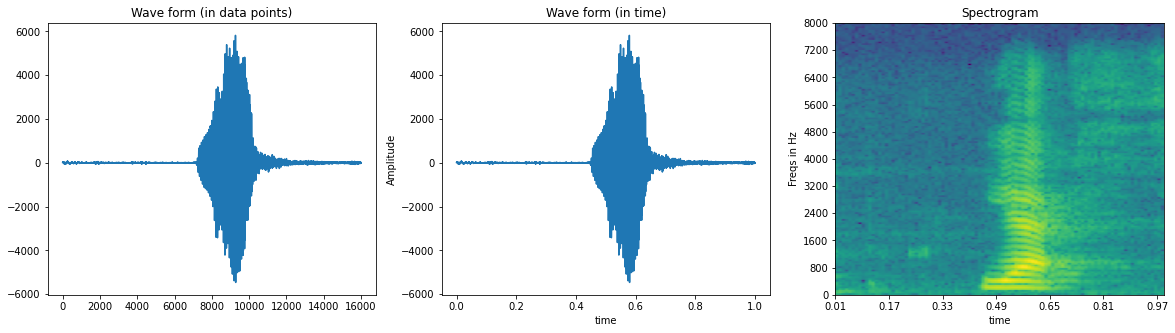

In [ ]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


fig = plt.figure(figsize=(20, 5))

filename = X[0]
sample_rate, samples = wavfile.read(filename)

ax1 = fig.add_subplot(131) # 1,2,1 the first image
plt.plot(samples)
plt.title("Wave form (in data points)")

ax2 = fig.add_subplot(132) # 1,2,1 the first image
ax2.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)
ax2.set_title('Wave form (in time)')
ax2.set_xlabel('time')
ax2.set_ylabel('Amplitude')

freqs, times, spectrogram = log_specgram(samples, sample_rate)

ax3 = fig.add_subplot(133) # 1,2,2 the second image
ax3.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax3.set_yticks(freqs[::16])
ax3.set_xticks(times[::16])
ax3.set_title('Spectrogram')
ax3.set_ylabel('Freqs in Hz')
ax3.set_xlabel('time')
plt.show()

## MFCC feature transformation

In [ ]:
def get_mfcc_from_signal(signal):

    # extract MFCCs features
    single_mfcc = mfcc_spec(signal, 16000, window_stride=(400, 160), fft_size=512, num_filt=20, num_coeffs=13).T

    # dropping first coefficient
    single_mfcc = single_mfcc[1:,:] # keeping only 12 coefficients

    return single_mfcc

In [ ]:
# extract mfcc features from the waveforms

X_train_mfcc = [get_mfcc_from_signal(signal) for signal in tqdm(X_train_waveform,position=0)]
X_test_mfcc = [get_mfcc_from_signal(signal) for signal in tqdm(X_test_waveform,position=0)]
X_val_mfcc = [get_mfcc_from_signal(signal) for signal in tqdm(X_val_waveform,position=0)]

100%|██████████| 800/800 [00:01<00:00, 501.07it/s]


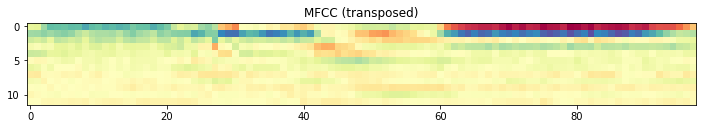

shape (transposed): (12, 98)
6400


In [ ]:
plt.figure(figsize=(12, 4))
plt.imshow(X_train_mfcc[0],cmap='Spectral')
plt.title("MFCC (transposed)")
plt.show()

print('shape (transposed):', np.array(X_train_mfcc[0]).shape)
print(len(X_train_mfcc))

In [ ]:
# transform shape of training data

X_train_mfcc_expanded = np.expand_dims(X_train_mfcc, axis=-1)
print('train tensor shape:', X_train_mfcc_expanded.shape)

X_val_mfcc_expanded = np.expand_dims(X_val_mfcc, axis=-1)
print('validation tensor shape:', X_val_mfcc_expanded.shape)

X_test_mfcc_expanded = np.expand_dims(X_test_mfcc, axis=-1)
print('test tensor shape:', X_test_mfcc_expanded.shape)

nb_classes = len(np.unique(y))

y_train = np.eye(nb_classes, dtype='uint8')[y_train]
print('train labels shape:', y_train.shape)

y_val = np.eye(nb_classes, dtype='uint8')[y_val]
print('validation labels shape:', y_val.shape)

y_test = np.eye(nb_classes, dtype='uint8')[y_test]
print('test labels shape:', y_test.shape)

train tensor shape: (6400, 12, 98, 1)
validation tensor shape: (800, 12, 98, 1)
test tensor shape: (800, 12, 98, 1)
train labels shape: (6400, 8)
validation labels shape: (800, 8)
test labels shape: (800, 8)


## Model building

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

# model from https://ieeexplore.ieee.org/document/6857341
def CNN():
    mfcc = Input(shape=(12,98,1)) 

    conv_1 = Conv2D(filters=32, kernel_size=(8,15), strides=(1,1), activation= None, padding='same')(mfcc)
    norm_1 = BatchNormalization()(conv_1)
    activ_1 = Activation('relu')(norm_1)
    dropout_1 = Dropout(rate=0.1)(activ_1)
    max_pool = MaxPool2D(pool_size=(2, 2))(dropout_1)

    conv_2 = Conv2D(filters=32, kernel_size=(4,10),strides=(1,1), activation= None, padding='same')(max_pool)
    norm_2 = BatchNormalization()(conv_2)
    activ_2 = Activation('relu')(norm_2)
    dropout_2 = Dropout(rate=0.1)(activ_2)

    reshape = Flatten()(dropout_2)


    dense_1 = Dense(128, activation='relu')(reshape)
    dropout_3 = Dropout(rate=0.2)(dense_1)
    dense_2 = Dense(128, activation='relu')(dropout_3)

    output = Dense(nb_classes, activation='softmax')(dense_2)

    model = Model(inputs=mfcc, outputs=output)

    return model

model_cnn = CNN()

model_cnn.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.003), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 98, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 12, 98, 32)        3872      
                                                                 
 batch_normalization (BatchN  (None, 12, 98, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 12, 98, 32)        0         
                                                                 
 dropout (Dropout)           (None, 12, 98, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 49, 32)        0         
 )                                                           

## Model training (optimization)

In [ ]:
history_cnn = model_cnn.fit(X_train_mfcc_expanded, y_train, validation_data=(X_val_mfcc_expanded,y_val),batch_size=32, epochs=20, shuffle=True)
# history_cnn = model_cnn.fit(X_train_mfcc_expanded, y_train, batch_size=32, epochs=10, shuffle=True)

Epoch 1/20
200/200 [==============================] - 41s 199ms/step - loss: 1.7859 - accuracy: 0.3089 - val_loss: 1.4205 - val_accuracy: 0.4462
Epoch 2/20
200/200 [==============================] - 40s 200ms/step - loss: 1.3815 - accuracy: 0.4409 - val_loss: 1.1582 - val_accuracy: 0.5362
Epoch 3/20
200/200 [==============================] - 38s 192ms/step - loss: 1.1421 - accuracy: 0.5291 - val_loss: 1.0081 - val_accuracy: 0.6263
Epoch 4/20
200/200 [==============================] - 40s 199ms/step - loss: 0.9320 - accuracy: 0.6278 - val_loss: 0.7984 - val_accuracy: 0.7113
Epoch 5/20
200/200 [==============================] - 38s 192ms/step - loss: 0.7885 - accuracy: 0.6916 - val_loss: 0.6785 - val_accuracy: 0.7788
Epoch 6/20
200/200 [==============================] - 40s 198ms/step - loss: 0.6472 - accuracy: 0.7536 - val_loss: 0.6689 - val_accuracy: 0.8163
Epoch 7/20
200/200 [==============================] - 38s 191ms/step - loss: 0.5766 - accuracy: 0.7859 - val_loss: 0.5337 - val_ac

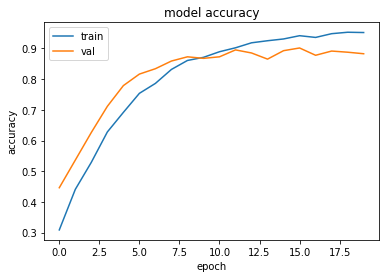

In [ ]:
def plot_history(history):
    plt.plot(history_cnn.history['accuracy'])
    plt.plot(history_cnn.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot_history(history_cnn)

## Model evaluation



In [ ]:
loss, accuracy = model_cnn.evaluate(X_test_mfcc_expanded, y_test, verbose = 1)

print('model accuracy:',accuracy)

25/25 [==============================] - 1s 43ms/step - loss: 0.4103 - accuracy: 0.8763
model accuracy: 0.8762500286102295


25/25 [==============================] - 1s 43ms/step


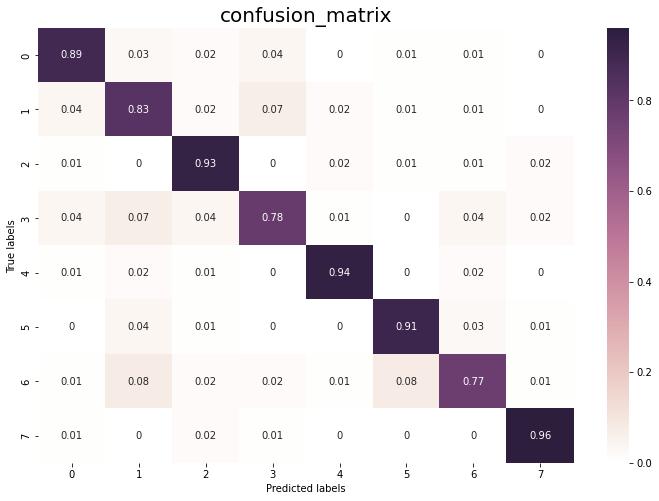

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import pandas as pd
import seaborn as sn

def show_confusion_matrix(pred, Y_TEST):
  
  
    cm = confusion_matrix(y_true=Y_TEST, y_pred=pred)
    cm = normalize(cm,axis=1,norm='l1')
  
    df_cm = pd.DataFrame(cm,
                        index=[i for i in encoder_mapping],
                        columns=[i for i in encoder_mapping])
  
    plt.figure(figsize=(12,8))
  
    cmap = sn.cubehelix_palette(light=1, as_cmap=True)
    sn.heatmap(df_cm, annot=True,cmap=cmap)
    plt.title('confusion_matrix',fontdict={'fontsize':20})
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show


  
pred = model_cnn.predict(X_test_mfcc_expanded, verbose=1)
pred = np.argmax(pred, axis=1)
show_confusion_matrix(pred, np.argmax(y_test, axis=1))

## Save model

In [ ]:
model_cnn.save('speech_recognition.h5')